In [1]:
from cluster import *
from load_data import *
from IPython.display import Image
from matplotlib import pyplot as plt
import sklearn, torch, random, numpy as np, pickle
from sklearn.model_selection import train_test_split
from os.path import isfile
from classes import *

seed_num = 10
torch.manual_seed(seed_num)
np.random.seed(seed_num) #also sets sklearn seed
random.seed(seed_num)

In [2]:
file = '../Data/stations.dat'
if not isfile(file):
    save_stations(file)
station_id, coord, groups = cluster(file)
coord = np.array(coord)

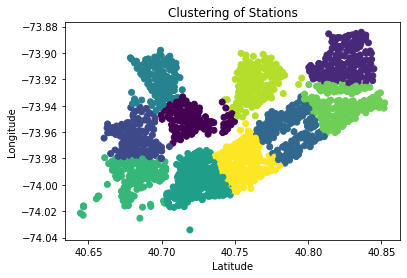

In [3]:
plt.scatter(coord[:, 0], coord[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster.png')
plt.show()

In [4]:
file = '../Data/data.dat'
if isfile(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
else:
    data = load({station_id[i]: groups[i] for i in range(len(station_id))}, file)

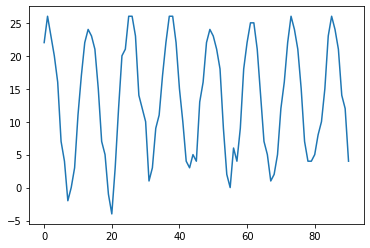

In [8]:
x, y, y2 = data
date = np.array(x)

dates = []
for i in x:
    dates.append((i[0]-2013)*12+i[1]-6)
plt.plot(dates, date[:, -3])
plt.title("Temperature Over Time")
plt.xlabel("Months Since Oct. 2013")
plt.ylabel("Temperature in ")
plt.show()

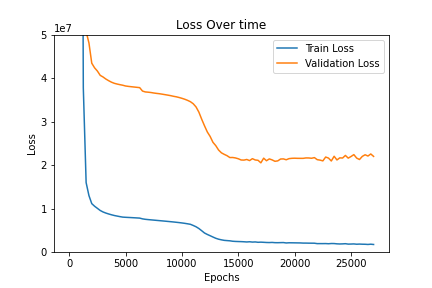

  0%|          | 0/200 [00:00<?, ?it/s]

tensor(230.1407, grad_fn=<MseLossBackward>)
tensor(198.2086, grad_fn=<MseLossBackward>)
tensor(161.3451, grad_fn=<MseLossBackward>)
tensor(131.3827, grad_fn=<MseLossBackward>)
tensor(105.8125, grad_fn=<MseLossBackward>)
tensor(81.0148, grad_fn=<MseLossBackward>)
tensor(52.5770, grad_fn=<MseLossBackward>)
tensor(26.8411, grad_fn=<MseLossBackward>)
tensor(12.3946, grad_fn=<MseLossBackward>)
tensor(8.7646, grad_fn=<MseLossBackward>)
tensor(6.4684, grad_fn=<MseLossBackward>)
tensor(6.0440, grad_fn=<MseLossBackward>)
tensor(5.8672, grad_fn=<MseLossBackward>)
tensor(5.6767, grad_fn=<MseLossBackward>)
tensor(5.5042, grad_fn=<MseLossBackward>)
tensor(5.3645, grad_fn=<MseLossBackward>)
tensor(5.2845, grad_fn=<MseLossBackward>)
tensor(5.1628, grad_fn=<MseLossBackward>)
tensor(5.0830, grad_fn=<MseLossBackward>)
tensor(5.0020, grad_fn=<MseLossBackward>)


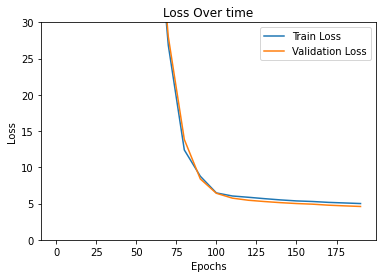

Ended at epoch 200 with loss of 4.597747325897217
0.0


In [5]:
x, y, y2 = torch.tensor(x).float(), torch.tensor(y).float(), torch.tensor(y2).float()
x_train, x_test, y_train, y_test, y2_train, y2_test = train_test_split(x, y, y2)
x_train, x_val, y_train, y_val, y2_train, y2_val = train_test_split(x_train, y_train, y2_train)

repair = NN(len(x_train[0]), len(y_train[0]), [10]*4)
file = '../Data/repair.pt'
if isfile(file):
    img = Image(filename='../Graphs/Repair.png')
    display(img)
    repair.load_state_dict(torch.load(file))
    repair.eval()
else:
    repair.learn((x_train, y_train), (x_val, y_val), file='../Graphs/Repair', ylim=5e7)
    torch.save(repair.state_dict(), file)  

demand = NN(len(x_train[0]), len(y2_train[0]), [10] * 21)
file = '../Data/demand.pt'
if isfile(file):
    img = Image(filename='../Graphs/Demand.png')
    display(img)
    demand.load_state_dict(torch.load(file))
    demand.eval()
else:
    demand.learn((x_train, y2_train), (x_val, y2_val), file='../Graphs/Demand', ylim=30, epochs=200)
    torch.save(demand.state_dict(), file)  

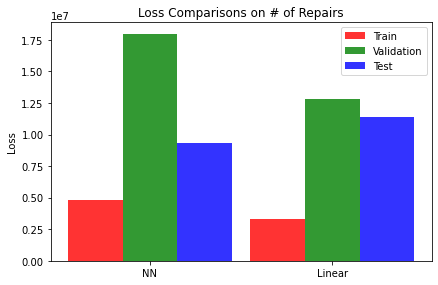

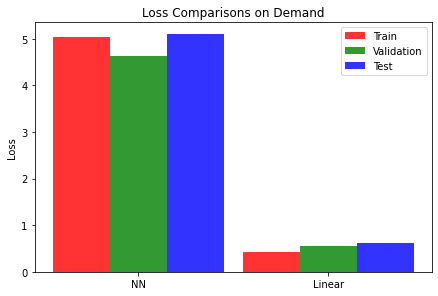

In [6]:
repair_linear = LinearRegression().fit(x_train, y_train)

demand_linear = MultiOutputLinear()
demand_linear.fit(x_train, y2_train)
losses = []
r_linear = LinearRegression().fit(x_train, y_train)
for x, y1, y2 in [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)]:
    neural = repair(x)
    linear = torch.tensor(r_linear.predict(x))
    losses.append((int(repair.loss_f(neural, y1)), int(repair.loss_f(linear, y1))))
index = np.arange(2)
for i, c, l in [(0, 'r', 'Train'), (1, 'g', 'Validation'), (2, 'b', 'Test')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.3, ('NN', 'Linear'))
plt.legend()
plt.tight_layout()
plt.title('Loss Comparisons on # of Repairs')
plt.ylabel('Loss')
plt.savefig('../Graphs/repair_loss.png')
plt.show()

losses = []
for x, y1, y2 in [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)]:
    neural = demand(x)
    linear = torch.tensor(demand_linear.predict(x))
    losses.append((float(demand.loss_f(neural, y2)), float(demand.loss_f(linear, y2))))
index = np.arange(2)
for i, c, l in [(0, 'r', 'Train'), (1, 'g', 'Validation'), (2, 'b', 'Test')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.3, ('NN', 'Linear'))
plt.legend()
plt.tight_layout()
plt.title('Loss Comparisons on Demand')
plt.ylabel('Loss')
plt.savefig('../Graphs/repair_demand.png')
plt.show()